<a href="https://colab.research.google.com/github/spregler/Digital-Communications/blob/main/16QAM_Hamming2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
import numpy as np
import pandas as pd
from functools import reduce
import matplotlib.pyplot as plt

''' Simulation of Gray coded 16-QAM 
    1) Generate random bitstream that represents encoded source symbols
    2a) Modulate binary codewords using a Gray Code
    2b) Modulate binary codewords using a (7,4) Hamming Code
    3a) Pass Gray Code through a Gaussian channel with power = 1/5
    3b) Pass Hamming Code through the same channel
    4) Demodulate signals using hard-decision regions
    5) Compare BER 
'''

' Simulation of Gray coded 16-QAM \n    1) Generate random bitstream that represents encoded source symbols\n    2a) Modulate binary codewords using a Gray Code\n    2b) Modulate binary codewords using a (7,4) Hamming Code\n    3a) Pass Gray Code through a Gaussian channel with power = \n    3b) Pass Hamming Code through the same channel\n    4) Demodulate signals using hard-decision regions\n    5) Compare BER \n'

In [21]:
''' 1) Generate random bitstream that represents encoded source symbols '''

NUM_BITS = 7000
M = 16
k = 4
NUM_SYMBOLS = NUM_BITS//k
np.random.seed = 42

# Create binary array of size num_bits
BIT_SEQ = np.random.randint(2, size=NUM_BITS)

# Create LUT used for modulating siganl. The result of divmod is used to index the LUT in such a way that adjacent signals differ by only 1 bit.
LUT = np.array([-3, -1, 3, 1])

In [22]:
''' 2a) Modulate binary codewords using a Gray Code '''

def Gray(arr):
  # Group bit sequence into groups of 4 using a matrix where each row corresponds to a codeword
  codewords = np.reshape(arr, (NUM_BITS//k, k))
  # Convert from binary to decimal
  codewords_dec = codewords.dot(1 << np.arange(codewords.shape[-1] - 1, -1, -1))

  (x,y) = np.divmod(codewords_dec, 4)

  R = LUT[x] # Real component
  I = LUT[y] # Imaginary component

  signal = R+1j*I

  return signal

In [30]:
''' 2b) Modulate binary codewords using a (7,4) Hamming code '''

# Define Parity matrix
p1 = np.array([[0, 1, 1, 1]]).T
p2 = np.array([[1, 0, 1, 1]]).T
p3 = np.array([[1, 1, 0, 1]]).T
P = np.concatenate((p1, p2, p3), axis=1)


def encode(message):
	# Define Generator Matrix
	G = np.concatenate((P, np.eye(4)), axis=1)
	# Encode message using U=mG
	codeword = []
	for col in range(G.shape[1]):
		codeword.append(int(message.dot(G[:,col]) % 2 ))
	
	return codeword


def hamming_decode(received):
	# Define the check matrix H
	H = np.concatenate((np.eye(3), P.T), axis=1)
	# Define the syndrome 
	syndrome = []
	for col in range(H.T.shape[1]):
		syndrome.append(int(received.dot(H.T[:, col]) % 2))

	''' If the syndrome is all 0s, then the recived message is a valid codeword. Because of the one-to-one correspondence 
	between correctable error patterns and syndromes. '''
	if np.any(syndrome):
		loc = reduce(lambda a,b: 2*a+b, syndrome)-1
		valid_codeword = np.copy(received) 
		valid_codeword[int(loc)] = (valid_codeword[int(loc)] + 1) % 2
		print("Received: ", received, "Corrected: ", valid_codeword)
		return valid_codeword

	else: 
		return received


def Hamming(arr):
  # Group bit sequence into groups of 4 using a matrix where each row corresponds to a codeword
  message = np.reshape(arr, (NUM_BITS//k, k))
  # Iterate through each row of matrix, encoding each 4-bit codeword
  temp = [] 
  for row in message:
    temp.append(encode(np.array(row)))
  # Result is a matrix  where each row corresponds to a 7-bit Hamming code
  codewords = np.array(temp)

  # Convert from binary to decimal
  codewords_dec = codewords.dot(1 << np.arange(codewords.shape[-1] - 1, -1, -1))

  ''' Implement Pregler modulation '''
  # Here, x and y are the quotient and remainder of each 7-bit codeword divided by 8
  (x,y) = np.divmod(codewords_dec, 8)
  
  # For each 7-bit codeword, the result of dividing by 8 is equal to 
  x = np.floor(x/4).astype(int)
  y = np.floor(y/2).astype(int)

  # Modulate using LUTs
  R = LUT[x]
  I = LUT[y]
  signal = R+1j*I

  return signal

In [ ]:
''' Disregard this cell for now '''
# if __name__ == '__main__':
# 	listNums = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# 	codeWords = []

# # Quick test for Seth
# 	for i in listNums:
# 		res = [int(j) for j in list('{0:04b}'.format(listNums[i]))]
# 		codeWords.append(res)
	
# 	messageSet = []
# 	for row in np.array(codeWords):
# 		messageSet.append(encode(np.array(row)))

In [31]:
''' 3a) Pass Gray Code through a Gaussian channel with unit power and variance = 1/5 '''

def addNoise(signal):
  noise = (np.random.randn(NUM_SYMBOLS) + 1j*np.random.randn(NUM_SYMBOLS))/np.sqrt(5)
  noisy_signal = signal + noise

  # Plot constellation
  plt.scatter(noisy_signal.real, noisy_signal.imag, color='blue')
  plt.show()
  
  # Return statistics about symbols
  data, counts = np.unique(signal, return_counts=True)
  df_describe = pd.DataFrame(counts)
  print(df_describe.describe())

  return 0

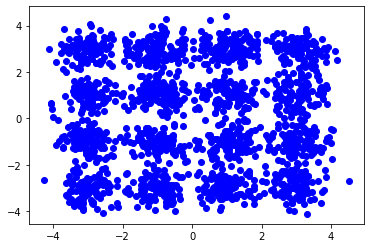

                0
count   16.000000
mean   109.375000
std      9.576882
min     98.000000
25%    104.500000
50%    106.000000
75%    111.750000
max    133.000000


0

In [32]:
''' 3a) Pass Gray Code through a Gaussian channel with power = 1/5 '''
addNoise(Gray(BIT_SEQ))

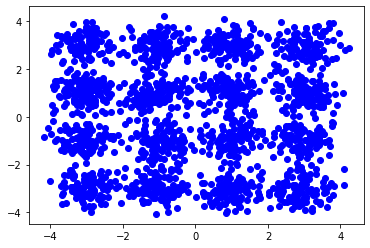

                0
count   16.000000
mean   109.375000
std      9.576882
min     98.000000
25%    104.500000
50%    106.000000
75%    111.750000
max    133.000000


0

In [33]:
''' 3b) Pass Hamming Code through the same channel '''
addNoise(Hamming(BIT_SEQ))

In [ ]:
# Prototype to use in correlation calculation for signal decision
prototype_dec = np.asarray(messageSet).dot(1 << np.arange(np.asarray(messageSet).shape[-1] - 1, -1, -1))
(w,z) = np.divmod(prototype_dec, 8)
w = np.floor(w/4).astype(int)
z = np.floor(z/2).astype(int)
W = alpha[w]
Z = alpha[z]
prot_signal = W+1j*Z
#
prototype = np.array(list(zip(prot_signal.real, prot_signal.imag)))
received = np.array(list(zip(noisySignal2.real, noisySignal2.imag)))
# Dot product now
dot_prod = np.dot(prototype, received.T)
received_norm = np.linalg.norm(received, axis=1)
prototype_norm = np.linalg.norm(prototype, axis=1)
norm_product = np.asarray([received_norm * prototype_norm[i] for i in range(prototype_norm.shape[0])])

dProduct = np.divide(dot_prod.T, norm_product.T)

cosine = np.abs(1 - dProduct)
index_min = np.argmin(cosine, axis=1)

decision = prototype[index_min]

correct_cnt = 0
for idx in range(decision.shape[0]):
  if (decision[idx][0] == signal2.real[idx]) and (decision[idx][1] == signal2.imag[idx]):
    correct_cnt += 1

SER = 1 - correct_cnt/num_symbols
BER = SER/4
print(SER)
print(BER)

0.25028571428571433
0.06257142857142858


In [ ]:
# Some quick stats
print(np.unique(signal2, return_counts=True))

data, counts = np.unique(signal2, return_counts=True)
df_describe = pd.DataFrame(counts)
df_describe.describe()

(array([-3.-3.j, -3.-1.j, -3.+1.j, -3.+3.j, -1.-3.j, -1.-1.j, -1.+1.j,
       -1.+3.j,  1.-3.j,  1.-1.j,  1.+1.j,  1.+3.j,  3.-3.j,  3.-1.j,
        3.+1.j,  3.+3.j]), array([110,  97, 103, 104, 119, 124, 106, 104, 107, 110,  98, 108, 131,
       116,  96, 117]))


,0
count,16.000000
mean,109.375000
std,9.851396
min,96.000000
25%,103.750000
50%,107.500000
75%,116.250000
max,131.000000


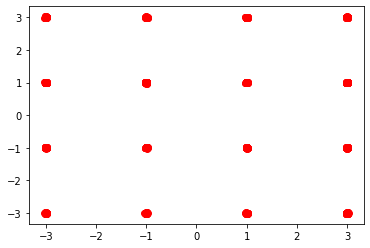

In [ ]:
noisySignal2 = signal2 + noise
plt.scatter(noisySignal2.real, noisySignal2.imag, color='red')
plt.show()

In [ ]:
# Now for Gray #################################################################
prototype2 = np.array([[-3, -3],
              [-3, -1],
              [-3, 3],
              [-3, 1],
              [-1, -3],
              [-1, -1],
              [-1, 3],
              [-1, 1],
              [-3, -3],
              [3, -1],
              [3, 3],
              [3, 1],
              [1, -3],
              [1, -1],
              [1, 3],
              [1, 1 ]])

received2 = np.array(list(zip(noisySignal.real, noisySignal.imag)))
# Dot product now
dot_prod2 = np.dot(prototype2, received2.T)
received_norm2 = np.linalg.norm(received2, axis=1)
prototype_norm2 = np.linalg.norm(prototype2, axis=1)
norm_product2 = np.asarray([received_norm2 * prototype_norm2[i] for i in range(prototype_norm2.shape[0])])
dProduct2 = np.divide(dot_prod2.T, norm_product2.T)

In [ ]:
cosine2 = np.abs(1 - dProduct2)
index_min2 = np.argmin(cosine2, axis=1)
decision2 = prototype2[index_min2]

In [ ]:
correct_cnt2 = 0
for idx in range(decision2.shape[0]):
  if (decision2[idx][0] == signal.real[idx]) and (decision2[idx][1] == signal.imag[idx]):
    correct_cnt2 += 1
correct_cnt2

1330

In [ ]:
SER_gray = 1 - correct_cnt2/num_symbols
BER_gray = SER_gray/4
print(SER_gray)
print(BER_gray)

0.24
0.06
